<a href="https://colab.research.google.com/github/Aayushee07/AdsLabs/blob/main/aayushi_ads_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ADS LAB 5**

Dataset : [link](https://www.kaggle.com/code/akashsdas/predict-hr-stay-or-leave/input)

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, learning_curve,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, log_loss,
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve,
    auc
)
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier


In [17]:
# Loading the dataset
df = pd.read_csv('/content/HR_comma_sep.csv')
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
10091,0.51,1.00,5,196,4,0,0,0,sales,medium
9171,0.30,0.58,2,124,3,0,0,0,sales,low
11945,0.94,0.73,3,268,10,0,0,0,technical,medium
1682,0.59,1.00,3,156,4,0,1,0,accounting,low
13579,0.56,0.67,3,270,2,0,0,0,sales,medium


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [18]:
def plot_countplot(column, ax=None):
    with sns.axes_style('ticks'):
        sns.countplot(x=column, palette=sns.color_palette('rocket'), ax=ax)
        sns.despine(offset=6)

**Imbalanced,how much?**

HR stay - 76.19%
HR leave - 23.81%


<ipython-input-18-6892838de023>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, palette=sns.color_palette('rocket'), ax=ax)
<ipython-input-18-6892838de023>:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x=column, palette=sns.color_palette('rocket'), ax=ax)


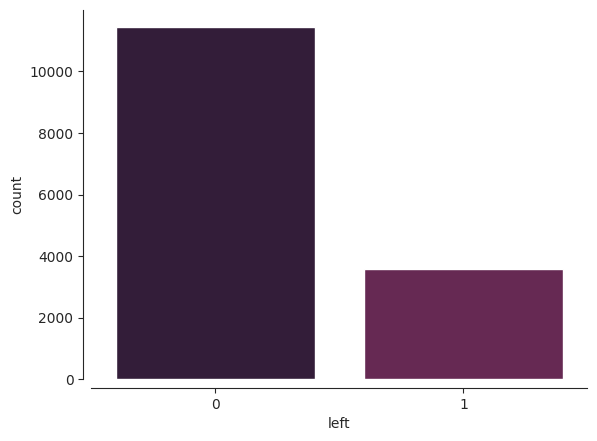

In [19]:
# Looking at how much is the dataset imbalanced?

num_of_stay = round(len(df[df.left == 0]) / len(df) * 100, 2)
print(f'HR stay - {num_of_stay}%')
print(f'HR leave - {round(100 - num_of_stay, 2)}%')

plot_countplot(df.left)

In [20]:
replacement = {
    'low': 0,
    'medium': 1,
    'high': 2
}

df.salary = df.salary.apply(lambda x: replacement[x])
df.salary[:5]

0    0
1    1
2    1
3    0
4    0
Name: salary, dtype: int64

In [21]:
ohe = OneHotEncoder()

dept_ohe_df = pd.DataFrame(df.Department)
dept_ohe_df = pd.DataFrame(
    ohe.fit_transform(dept_ohe_df[['Department']]).toarray()
)

print(f'Unique Departments: {len(df.Department.unique())}')

Unique Departments: 10


In [22]:
col_names = []
for col_name in ohe.get_feature_names_out():
    col_name = col_name.split('_')[1]
    col_names.append(col_name)

col_names

['IT',
 'RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product',
 'sales',
 'support',
 'technical']

In [23]:
dept_ohe_df.columns = col_names
dept_ohe_df.head()

,IT,RandD,accounting,hr,management,marketing,product,sales,support,technical
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
# Target column
y = df[['left']]
y.head()

,left
0,1
1,1
2,1
3,1
4,1


In [25]:
# Adding the ohe results and removing `left` column

df = df.drop(['Department', 'left'], axis='columns')
df = pd.concat([dept_ohe_df, df], axis='columns')
df.head()

x = df.copy()
x.head()

,IT,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.38,0.53,2,157,3,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.80,0.86,5,262,6,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.11,0.88,7,272,4,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.72,0.87,5,223,5,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.37,0.52,2,159,3,0,0,0


**Modelling**

In [26]:
# Scaling the dataset
for column in x.columns:
    x[column] = StandardScaler().fit_transform(x[column].values.reshape(-1, 1))

x.head()

,IT,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,-0.933368
1,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,0.752814,0.840707,0.971113,1.220423,1.713436,-0.411165,-0.147412,0.636092
2,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-2.022479,0.957554,2.593763,1.420657,0.343655,-0.411165,-0.147412,0.636092
3,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,0.431041,0.899131,0.971113,0.439508,1.028546,-0.411165,-0.147412,-0.933368
4,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,-0.933368


**Balancing the unbalanced dataset**

In [27]:
# Creating train and test datasets using x and y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

# Creating train and cross-validation datasets using the x_train and y_train
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_cv)}')
print(f'Test set size: {len(x_test)}')

Training set size: 8399
Validation set size: 2100
Test set size: 4500


**SMOTE to balance the data**

In [28]:
# Oversampling to balance the data

_smote = SMOTE(random_state=0)

sm_cols = x_train.columns

x_train, y_train = _smote.fit_resample(x_train, y_train)
x_train = pd.DataFrame(data=x_train, columns=sm_cols)
y_train = pd.DataFrame(data=y_train, columns=['left'])

# We can Check the numbers of our data
print(f'Length of oversampled data is {len(x_train)}')

print(f'Number of left no {len(y_train[y_train.left == 0])}')
print(f'Number of left yes {len(y_train[y_train.left == 1])}')

print(f'Proportion of left no data in oversampled data is {len(y_train[y_train.left == 0])/len(x_train)}')
print(f'Proportion of left yes data in oversampled data is {len(y_train[y_train.left == 1])/len(x_train)}')

Length of oversampled data is 12838
Number of left no 6419
Number of left yes 6419
Proportion of left no data in oversampled data is 0.5
Proportion of left yes data in oversampled data is 0.5


In [30]:
# For cross validation
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

col_names.remove('IT') # since IT is dropped
col_names

x_cv = np.array(x_cv)
x_cv = x_cv.astype('int')
y_cv = np.array(y_cv)

In [33]:
models = [
 RandomForestClassifier(),
]

In [34]:
def cross_val_score(models, x_cv, y_cv):
    for model in models:
        scores = []
        for train, test in skf.split(x_cv, y_cv):
            x_train, x_test = x_cv[train], x_cv[test]
            y_train, y_test = y_cv[train], y_cv[test]

            _smote = SMOTE(random_state=0)
            x_train_sm, y_train_sm = _smote.fit_resample(x_train, y_train)

            model.fit(x_train_sm, y_train_sm)

            score = model.score(x_test, y_test)
            scores.append(score)

        print(f'== {model} ==')
        print(f'Cross-Validation mean-score: {np.mean(score)}')
        print()


cross_val_score(models, x_cv, y_cv)

== RandomForestClassifier() ==
Cross-Validation mean-score: 0.9619047619047619



In [35]:
rfe = RandomForestClassifier()

rfe = RFE(rfe, n_features_to_select=5)
rfe.fit(x_train, y_train.values.ravel())

selector = rfe.support_

print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False  True  True
  True  True  True False False False]
[11 10  9  7 12 13 14  5  6  4  1  1  1  1  1  2  8  3]


In [36]:
def rfe(model, x_cv, y_cv):
    # number of features
    nof_list = np.arange(1, 17 + 1)
    high_score = 0

    # variable to store the optimum features
    nof = 0
    score_list = []

    for n in range(len(nof_list)):
        x_train, x_test, y_train, y_test = train_test_split(
            x_cv, y_cv, test_size=0.3, random_state=0
        )

        _smote = SMOTE(random_state=0)
        x_train_sm, y_train_sm = _smote.fit_resample(x_train, y_train)

        rfe = RFE(model, n_features_to_select=nof_list[n])
        x_train_rfe = rfe.fit_transform(x_train_sm, y_train_sm)
        x_test_rfe = rfe.transform(x_test)

        model.fit(x_train_rfe, y_train_sm)

        score = model.score(x_test_rfe, y_test)
        score_list.append(score)

        if score > high_score:
            high_score = score
            nof = nof_list[n]

    return (nof, high_score)


nof, high_score = rfe(RandomForestClassifier(), x_cv, y_cv)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.957143


In [37]:
# Selected features

col = (x_train.columns)
result = itertools.compress(col, selector)

col_names = []
for c in result:
    col_names.append(c)
    print(c)

satisfaction_level
last_evaluation
number_project
average_montly_hours
time_spend_company


In [38]:
x_train = x_train[col_names]
x_test = x_test[col_names]

len(col_names)

5

In [39]:
# Implementing the model

cols = col_names.copy()

x_train = x_train[cols]
y_train = y_train['left']

logit_model = sm.Logit(y_train, x_train)

result = logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.569957
         Iterations 6
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   left              Pseudo R-squared:  0.178     
Date:                 2024-03-29 14:59  AIC:               14644.2073
No. Observations:     12838             BIC:               14681.5081
Df Model:             4                 Log-Likelihood:    -7317.1   
Df Residuals:         12833             LL-Null:           -8898.6   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       6.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
satisfaction_level   -1.0111   0.0228 -44.3268 0.0000 -1.0558 -0.9664
last_evaluation 

In [40]:
def rt_param_selection(x, y, nfolds):
    criterion = ['gini', 'entropy']
    max_features = ['auto', 'sqrt', 'log2']
    param_grid = {'criterion': criterion, 'max_features': max_features}

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=nfolds)
    grid_search.fit(x, y)
    grid_search.best_estimator_
    return grid_search.best_estimator_


skf = StratifiedKFold(n_splits=10)
best_estimator_ = rt_param_selection(x_train, y_train, skf)
best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomForestClassifier(criterion='entropy', max_features='auto')

In [41]:
cross_val_score(best_estimator_, x_cv, y_cv)

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=1351897038) ==
Cross-Validation mean-score: 0.9238095238095239

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=1108193042) ==
Cross-Validation mean-score: 0.9142857142857143

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=1225781198) ==
Cross-Validation mean-score: 0.9285714285714286

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=1003559892) ==
Cross-Validation mean-score: 0.9142857142857143

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=176016618) ==
Cross-Validation mean-score: 0.9047619047619048

== DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=1108004196) ==
Cross-Validation mean-score: 0.91904761904

**Model Fitting**

In [42]:
# Fitting the model
model = best_estimator_
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='entropy', max_features='auto')

**Model Prediction**

In [43]:
y_test_pred = model.predict(x_test)
print(y_test_pred)
print(f"\nPrediction: \n{pd.DataFrame(y_test_pred)[0].value_counts()}")

[0 1 0 ... 1 0 0]

Prediction: 
0    3467
1    1033
Name: 0, dtype: int64


In [44]:
print(y_test.values.reshape(1, -1)[0])
print()
print(f"Actual: \n{pd.DataFrame(y_test)['left'].value_counts()}")


[0 1 0 ... 1 0 0]

Actual: 
0    3408
1    1092
Name: left, dtype: int64


**Model Evaluation**

In [45]:
print(f'Model Score: {model.score(x_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9828888888888889
f1-score: 0.982724768627451
precision score: 0.9830318132527468
recall score: 0.9828888888888889


In [46]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3408
           1       0.99      0.94      0.96      1092

    accuracy                           0.98      4500
   macro avg       0.99      0.97      0.98      4500
weighted avg       0.98      0.98      0.98      4500

